# Remote Sensing II

## Advanced plotting methods

In the last session, we only plotted the satellite data of MSG itself. Unfortunately, we have to follow our instincts (and duty) as Geographers and add some spatial context to the plots so that the viewer knows what exactly she or he sees.

So lets start with the natural color composite of Greece. 

First, we load the data again and resample the scene to our area definition of Greece and its surroundings:

In [1]:
import satpy
import numpy as np
import matplotlib.pyplot as plt
from pyresample.geometry import AreaDefinition

dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117120009.nc"]
files = {'seviri_l1b_nc' : dateien}

scn = satpy.Scene(filenames=files)
scn.load(["natural_color"])
scn.load(scn.all_dataset_names()[1:])

area_id = 'Griechenland'
description = 'Griechenland und Umgebung in Mercator-Projektion'
proj_id = 'Griechenland'
proj_dict = {'proj': 'merc', 'lat_ts': 38, 'lon_0': 25}

width = 800    # width of the result domain in pixels
height = 800   # height of the result domain in pixels

llx = -10E5   # projection x coordinate of lower left corner of lower left pixel
lly =  27E5   # projection y coordinate of lower left corner of lower left pixel
urx =  10E5   # projection x coordinate of upper right corner of upper right pixel
ury =  47E5   # projection y coordinate of upper right corner of upper right pixel

area_extent = (llx,lly,urx,ury)
area_def = AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

local_scn = scn.resample(area_def)

Now, we can plot the scene and add some coastlines and a lat/lon grid:

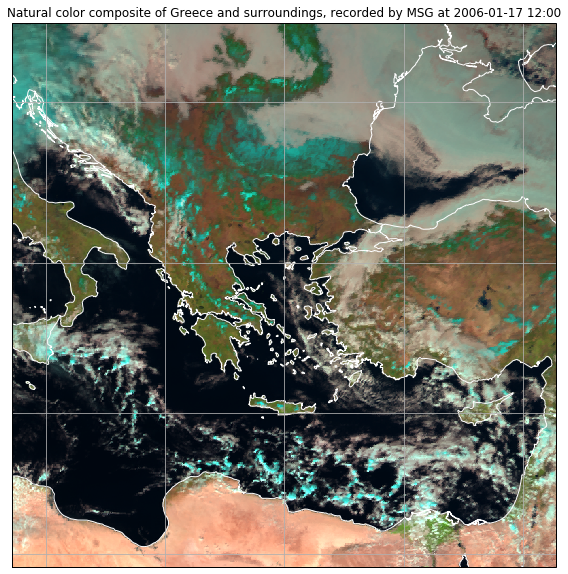

In [11]:
# First, we have to transpose the natural color composite values to a shape that can be interpreted 
# by the imshow method: (M,N,3)
image = np.asarray(local_scn['natural_color']).transpose(1,2,0)

# Then we scale the values to the range between 0 and 1, clipping the lower and upper percentiles
# so that a potential contrast decrease caused by outliers is eliminated.
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

# Now we "copy" the coordinate reference system of our composite data set...
crs = local_scn['natural_color'].attrs['area'].to_cartopy_crs()

# ... and use it to generate an axes in our figure with the same CRS
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)

# Now we can add some coastlines...
ax.coastlines(resolution="10m",color="white")

# ... and a lat/lon grid:
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin='upper')

# and add a title to our plot
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))

# Finally, we can show the plot to the user:
plt.show()

If you want to add further shapes to the plot, you can do so by using the `feature` class of cartopy:

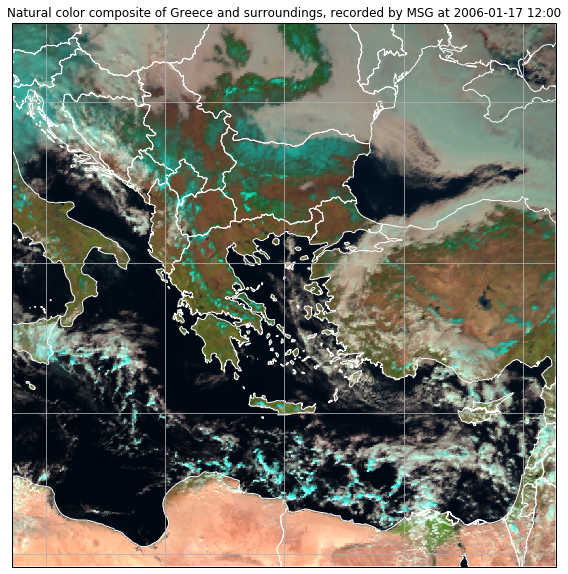

In [13]:
import cartopy.feature as cfeature

image = np.asarray(local_scn['natural_color']).transpose(1,2,0)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = local_scn['natural_color'].attrs['area'].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# ===================================================
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='white')
# ===================================================

ax.imshow(image, transform=crs, extent=crs.bounds, origin='upper')
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()

## Band calculations

As SatPy's Scene class internally uses the xarray data structure to store its data sets, you can do various calculations on these bands with ease.

Often, you will need the difference valus of two bands, which help to highlight certain atmospheric features. For example, the difference values between the bands at 10.8μm and 3.9μm help to distinguish low stratus layers from higher clouds at night.

So, let's first load the MSG scene at 00:00 UTC on 17. January 2006 and resample it to the area of Greece again:

In [12]:
dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117000010.nc"]
files = {'seviri_l1b_nc' : dateien}

scn = satpy.Scene(filenames=files)
scn.load(scn.all_dataset_names()[1:])

local_scn = scn.resample(area_def)

We can now calculate the difference values by simply subtracting the bands from each other with the `-` operator and we can store them in a new data set within the Scene object:

In [13]:
local_scn["band_diff"] = local_scn["IR_108"]-local_scn["IR_039"]

Let's see what we got:

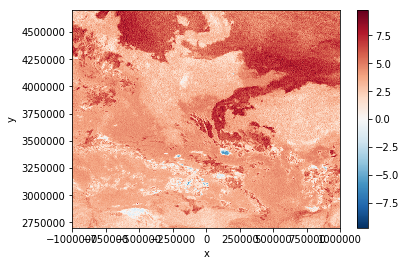

In [15]:
local_scn["band_diff"].plot.imshow()

High difference values indicate low stratus clouds. This means, the dark-red regions in the plot above are covered by low stratus.

By applying a threshold value (~5K), we can generate a low stratus cloud mask for our current scene:

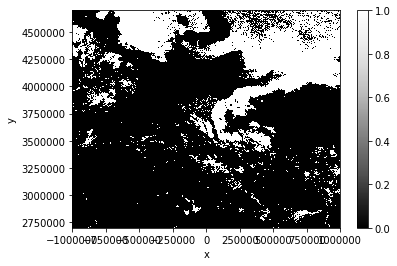

In [30]:
local_scn["stratus_mask"] = local_scn["band_diff"] > 5
local_scn["stratus_mask"].plot.imshow(cmap="Greys_r")

## Writing to disk

SatPy makes it possible to save datasets in multiple formats. Most of the time, the library is used to save the bands or composites of a satellite scene as images (e.g. PNG or TIFF) which are then provided to end users. You can do this using one of the built-in SatPy writers.

For example, let's write the band at 0.6μm to a simple greyscale PNG image:

In [18]:
local_scn.save_dataset(dataset_id="VIS006",
                       filename='VIS006.png',
                       writer='simple_image',
                       base_dir='../data/output')

You can also save multiple or all datasets of a scene simultaneously using the `save_datasets()` method:

In [19]:
scn.save_datasets(writer='simple_image',
                  datasets=["VIS006","IR_108","natural_color"],
                  filename='{name}_{start_time:%Y%m%d_%H%M%S}.png',
                  base_dir='../data/output')

You can also easily save your data in formats like NetCDF or GeoTIFF for further manipulation in other software tools or for distribution to third parties that are not used to work with satellite data types:

In [20]:
scn.save_datasets(writer='cf',
                  datasets=["VIS006","IR_108","natural_color"],
                  filename='{start_time:%Y%m%d_%H%M%S}.nc',
                  base_dir='../data/output')

No time dimension in datasets, skipping time bounds creation.
